## Import libraries

In [134]:
import matplotlib.pyplot as plt
import scipy.stats as scst
import numpy as np 
plt.style.use('ggplot')

Assumptions:

 - The prey population finds ample food at all times.
 - The food supply of the predator population depends entirely on the size of the prey population.
 - The rate of change of population is proportional to its size.
 - During the process, the environment does not change in favour of one species, and genetic adaptation is inconsequential.
 - Predators have limitless appetite.

### Probablistic model

In [135]:
def mean_revert_rand_walk_gausian_step(temp = [17], temp_steps = 100000):
    '''
    This random walk prevents variance from exploding to infinity. For each temperature value
    check where it falls in the cumulative distribution function with mean equlas to temp[0]. 
    Toss a coin w/ prob heads = p_right. If it falls on heads then we sample a truncated normal 
    r.v from [0, inf) else we sample from truncated normal (-inf, 0]. The long running mean will still be 17
    with variance approx. scale^2.
    
    -------------------
    Parameters:
    temp (list of float): a list of one element with an intial tempertaure value (mean) in its first element 
    temp_steps (int): # steps to run the function
    -------------------
    Returns: 
    temp (list of floats): the temperatures observed during the random walk
    probs (list of floats): each temperature value is converted to a score between 0 to 1/10
    which indicates the mingling probability of foxes (higher temperature, more mingling). 
    This argument will be an input to mort_prey function.   
    '''
    
    while True:
        curr_val = temp[-1] - temp[0]
        cdf_val = scst.norm.cdf(curr_val, loc = 0, scale = 3)    
        p_right = 1 - cdf_val
        
        p = 'R' if (np.random.uniform(0, 1) <= p_right) else 'L'
        
        if p=='R':
            temp.append(temp[-1] + scst.truncnorm.rvs(a = 0, b = np.inf ,loc = 0, scale = 3))

        else:
            temp.append(temp[-1] + scst.truncnorm.rvs(a = - np.inf , b = 0, loc = 0, scale = 3))


        if (len(temp) >= temp_steps):
            break
    shifted_temp = np.array(temp)  - (min(temp))
    return temp,  shifted_temp / (max(shifted_temp) * 10)

In [136]:
def reproduce(γ, mort_p, foxes):
    '''
    reproduction rate per prey eaten by pairs of foxes
    ---------------------
    Parameters:
    γ (float): constant reproduction rate per prey eaten 
    mort_p (int): # rabbits eaten at a previous timestamp t - i
    foxes (int):  # foxes at timestamp t 
    ---------------------
    Returns:
    int additional foxes born 
    
    '''
    rep_rate = 2 * (mort_p / max(foxes, 1)) * γ if ((mort_p / max(foxes, 1)) * γ <= 0.5) else 1
    if (foxes <= 1):
        return 0
    else: 
        ## assume every fox gets equal share from prey
        return np.random.binomial(np.floor(foxes / 2), rep_rate)

In [137]:
def spieces_mort(a, idx, θ):
    '''
    Mortality rate of a spieces
    -----------------------
    Parameters:
    a (array of int): # of animals at each idx (timestamp) 
    idx (int): index of the timestamp to be affected by mortality
    θ (float): mortality rate 
    -----------------------
    Returns:
    int # animals which died
    '''
    n = 0 if a[idx - 1] < 0 else a[idx - 1]
    return np.random.binomial(n, θ)  

In [138]:
def mort_prey(probs, θ, idx, rabbit, fox):
    '''
    Each rabbit could be killed by the mingled foxes (which are determined by the temperature)
    Each fox has the same chance to kill independently each living rabbit. But once a rabbit has 
    been killed by a fox it can't die again. Also, we can't have more dead rabbits than rabbits alive.
    ----------------------
    Parameters:
    probs (list of floats): probability for foxes to mingle with rabbits 
    θ (float): mortality rate 
    idx (int): index of the timestamp to be affected by mortality
    rabbit (list of ints):
    fox (list of ints):
    ---------------------
    Returns:
    int # of rabbits which died 
    
    '''
    temp_l = rabbit[:]
    temp = rabbit[idx - 1]
    n = 0 if fox[idx - 1] < 0 else fox[idx - 1]
    mingled_foxes = np.random.binomial(n, probs[idx - 1])
    for fox in range(mingled_foxes):
#         print('fox num: ', fox)
        temp =  temp - spieces_mort(temp_l, idx, θ)
        temp_l[idx - 1] = temp
#         print('rabbits left: ', temp)
        if temp <= 0:
            return rabbit[idx - 1]
    return rabbit[idx - 1] - temp

In [139]:
def growth_abs(rabbit, idx, δ):
    '''
    -----------------
    Parameters:
    rabbit (list of ints): # of rabbits per idx (timestamp)
    idx (int): index of the timestamp to be affected by growth
    δ (float):
    -----------------
    Returns:
    int number of additional rabbits born
    '''
    n = 0 if rabbit[idx - 1] <= 1 else rabbit[idx - 1]
    return np.random.binomial(np.floor(n / 2), δ)

### Differential equation model

In [140]:
def rabbit_fox_env(x0, y0, α, β, γ, δ, dt = 1e-3, len_t = 100):
    '''
    Simple loteka-volterra differential equation model - see https://en.wikipedia.org/wiki/Lotka–Volterra_equations
    for details of the underlying assumptions.
    
    ------
    Parameters:
    x0 (int): initial value for prey (Rabbits)
    y0 (int): initial value for Predator (Foxes)
    α  (float): intrinsic rate of prey population increase
    β  (float): predation rate coefficient
    γ  (float): predator mortality rate  
    δ  (float): reproduction rate of predators per prey eaten
    dt (float): time interval between events
    len_t (int): # of events
    ------------
    Returns:
    rabbit (list of floats): # of rabbits at time t
    fox (list of floats): # foxes at time t
    t (numpy array):  time intervals 
    x0 (int): initial value for prey (Rabbits)
    y0 (int): initial value for Predator (Foxes)
    
    '''
    rabbit = []; fox = []
    rabbit.append(x0); fox.append(y0) 
    t = np.arange(0, len_t, dt)
    for idx, _ in enumerate(t):
        if (idx == 0):
            continue
        r = rabbit[-1] ; f = fox[-1]
        # The term β * (f * r)  - reminds a binomial experiment.  
        rabbit.append(r + dt * (α * r - β * (f * r)))
        fox.append(f + dt * (δ * (f * r) - γ * f))
    return rabbit, fox, t, x0, y0

In [141]:
def multi_init_rabbit_fox_env(xs, ys, α, β, γ, δ):
    '''
    ------------
    Parameters:
    xs (list of int): initial values for prey (Rabbits)
    ys (list of int): initial values for Predator (Foxes)
    α  (float): intrinsic rate of prey population increase
    β  (float): predation rate coefficient
    γ  (float): reproduction rate of predators per 1 prey eaten
    δ  (float): predator mortality rate
    -----------
    Returns:
    rabbits (list of lists): each list contains # of rabbits according to init state xs
    foxes (list of lists): each list contains # of foxes according to init state ys
    xs (list of int): initial values for prey (Rabbits)
    ys (list of int): initial values for Predator (Foxes)
    
    '''
    rabbits = []
    foxes = []
    for x0, y0 in zip(xs, ys):
        rabbit, fox, t, x0, y0 = rabbit_fox_env(x0, y0, α, β, γ, δ)
        rabbits.append(rabbit)
        foxes.append(fox)
    
    
    return rabbits, foxes, xs, ys

In [142]:
def multi_phase_plot_rabbit_fox(rabbits, foxes, xs, ys):
    '''
    Phase plot for foxes and rabbits model.
    -------------------
    Parameters:
    rabbits (list of lists of floats): first output from rmulti_init_rabbit_fox_env
    foxes (list of lists of floats): second output from multi_init_rabbit_fox_env
    xs (list of int): initial value for prey (Rabbits)
    ys (list of int): initial value for Predator (Foxes)
    -------------------
    '''
    fig, ax = plt.subplots(figsize=(9,5))
    ax.set_xlabel('Rabbit population')
    ax.set_ylabel('Fox population')
    ax.set_title('Phase space of Rabbits vs. Foxes population')
    ## Phase space is a plot ignoring time, so we only care what will be
    ## the rabbits vs. foxes population. 
    ## "This corresponds to eliminating time from the two differential equations above to produce a single differential equation"
    for rabbit, fox, x0, y0 in zip(rabbits, foxes, xs, ys):
        ax.scatter(rabbit, fox, label = "init prey: {}, pred: {}".format(str(x0), str(y0)))
    ax.legend()
    plt.show()

#### Input variables:

In [91]:
α, β, γ, δ = 1.1, 0.4, 0.4, 0.1
xs = [10, 10, 20, 15]
ys = [10, 20, 5, 5] 

In [92]:
rabbits, foxes, xs, ys = multi_init_rabbit_fox_env(xs, ys, α, β, γ, δ)

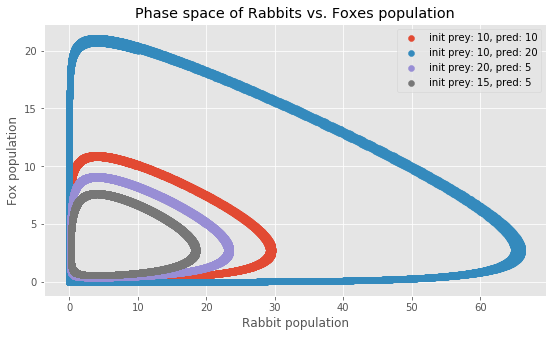

In [93]:
# Takes long time to run
multi_phase_plot_rabbit_fox(rabbits, foxes, xs, ys)

In [143]:
xs = [10, 10, 20, 15]
ys = [10, 20, 5, 5] 

In [144]:
temp, probs = mean_revert_rand_walk_gausian_step()
## probs are the mingling probabilities that depend on the temperatures

In [145]:
θ = np.random.beta(1, 10)
δ = np.random.beta(1, 5)
χ = np.random.beta(1, 10)
# reproduction rate per 1 prey eaten
γ = np.random.beta(1, 10)

In [146]:
if __name__ == '__main__':
    rabbits = []; foxes = []
    for x0, y0 in zip(xs, ys):
        rabbit = []; fox = []
        rabbit.append(x0); fox.append(y0)
        for idx, _ in enumerate(temp, start=1):
#           print('rabbit population: ', rabbit[-1])

            rab_growth = growth_abs(rabbit, idx, δ)
#           print('rabbit growth: ', rab_growth)
            rab_mort = mort_prey(probs, θ, idx, rabbit, fox)  
#           print('rabbit mortality: ', rab_mort)

            rabbit.append(rabbit[idx - 1]
                          + rab_growth
                          - rab_mort)

            if (rabbit[-1] <= 1):
                break

#           print('fox population: ', fox[-1])

            fox_rep = reproduce(γ, rab_mort, fox[idx - 1])
            fox_mort = spieces_mort(fox, idx, χ)

            fox.append(fox[idx - 1]   
                       + fox_rep
                       - fox_mort)

            if (fox[-1] <= 1):
                break
        rabbits.append(rabbit); foxes.append(fox) 

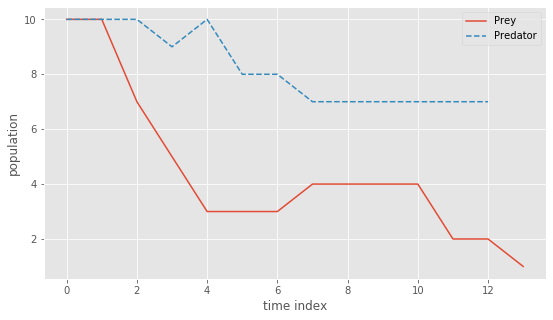

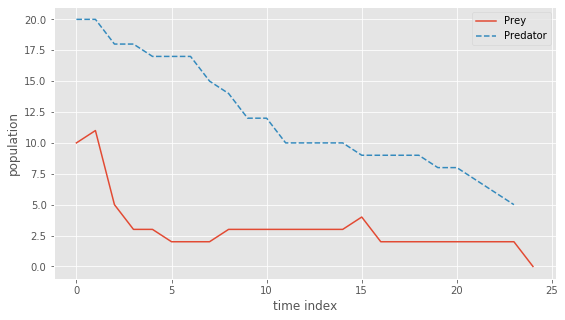

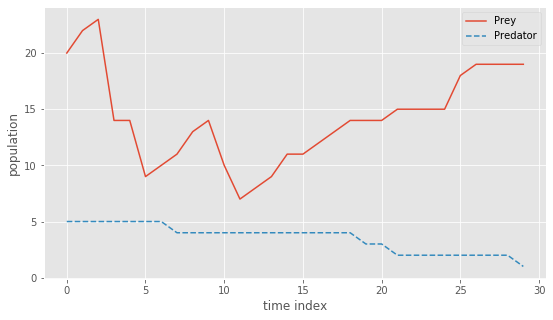

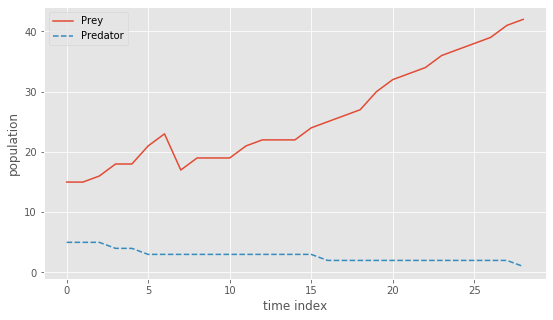

In [147]:
for r,f in zip(rabbits, foxes):
    fig, ax = plt.subplots(figsize=(9,5))
    ax.plot(range(len(r)), r, label='Prey')
    ax.plot(range(len(f)), f, '--', label='Predator')
    ax.grid(True)
    ax.legend()
    ax.set_ylabel('population')
    ax.set_xlabel('time index')
    plt.show()